&emsp;&emsp;最近工作需要爬取了较多网站，遇到比较头疼的是处理验证码，开始使用Python的pytesseract库，但是识别效果不是很好，于是决定自己手撸一个验证码识别库。

# 目标API

+ https://www.rclgroup.com/admin/CommonCx/captcha/captcha.jpg?v=2050

+ https://www.shipmentlink.com//servlet/TUF1_CaptchaUtils?d=1589938414501
 

## 生成验证码数据集

### 生成测试集

In [1]:
import os
import requests
from tqdm.notebook import tqdm

In [2]:
#图片获取接口
api_url_one = 'https://www.rclgroup.com/admin/CommonCx/captcha/captcha.jpg?v=2050'
api_url_two = 'https://www.shipmentlink.com//servlet/TUF1_CaptchaUtils?d=1589938414501'

    
def get_captcha(url,index):
    
    captcha_path = './captcha_sample/test/'
    if not os.path.exists(captcha_path):
        os.mkdir(captcha_path)
        
    try:
        r = requests.get(url,timeout=1.5)
        r.encoding = r.apparent_encoding
        if r.status_code == 200:
            with open(captcha_path+str(index)+'.jpg','wb') as pic:
                pic.write(r.content)
                pic.close()
    except BaseException as Be:
        print(Be)

    return 1
# 每个接口各自采集20张验证码保存在./captcha目录下
# 便于后续验证模型识别准确率
for i in tqdm(range(20)):
    get_captcha(api_url_one,2*i)
    get_captcha(api_url_two,2*i+1)
    

HTTPSConnectionPool(host='www.rclgroup.com', port=443): Max retries exceeded with url: /admin/CommonCx/captcha/captcha.jpg?v=2050 (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x7fc5117be810>, 'Connection to www.rclgroup.com timed out. (connect timeout=1.5)'))



### 生成训练集和验证集

&emsp;&emsp;使用Python的captcha生成训练数据集和验证数据集

In [2]:
from captcha.image import ImageCaptcha
from PIL import Image
import numpy as np
import random
import string

def captcha(width=128,height=128,char_num=4):
    
    image = ImageCaptcha(width,height)
    #设置验证码组成，数字+大写字母+小写字母
    characters = string.digits + string.ascii_uppercase + string.ascii_lowercase
    captcha_str = ''.join(random.sample(characters,char_num))
    img = image.generate_image(captcha_str)
    return img,captcha_str

In [3]:
from tqdm.notebook import tqdm
captcha_path = './captcha_sample/train/'
if not os.path.exists(captcha_path):
    os.mkdir(captcha_path)
imgs,labels = [],[]
for i in tqdm(range(10000)):
    img,cstr = captcha()
    imgs.append(img)
    labels.append(cstr)
    

## 验证码增强

In [4]:
import cv2
import tensorflow as tf
# 使用显卡进行时，将GPU的显存使用策略设置为 “仅在需要时申请显存空间”,不然会申请所有显存空间，报错
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
def CLAHE(img):
    grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 局部直方图均值化
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(grayimg)
    return cl1

def Histograms_Equalization(img):
        
    grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 直方图均值化
    equ = cv2.equalizeHist(grayimg)
    return equ

In [9]:
labels[0]

'UcMC'

In [19]:
from matplotlib import pyplot as plt
class ImageRecognition(object):

    def __init__(self):
        #字符字典大小:0-9 a-z A-Z _(验证码如果小于4，用_补齐) 一共63个字符
        self.char_index = 63
        self.path = ''
        
    def __char2pos__(self,char):
        if char == '_':
            k = 62
            return k
        # ord()用于返回单个字符的ASCII编码，数字0-9的编码从48开始
        k = ord(char) - 48
        if k > 9:
            k = ord(char) - 55
            if k > 35:
                k = ord(char) - 61
                if k > 61:
                    raise ValueError('No Map!')
        return k

    def text2vec(self,text):
        """
		文本转向量
		Parameters:
			text:文本
		Returns:
			vector:向量
		"""
        if len(text) > 4:
            raise ValueError('验证码最长4个字符')
 
        vector = np.zeros(4 * self.char_index)
		
        for i, c in enumerate(text):
            idx = i * self.char_index + self.__char2pos__(c)
            vector[idx] = 1
        return vector
    
    def vec2text(self, vec):
        """
		向量转文本
		Parameters:
			vec:向量
		Returns:
			文本
		"""
        char_pos = vec.nonzero()[0]
        text = []
        for i, c in enumerate(char_pos):
            char_at_pos = i #c/63
            char_idx = c % self.char_index
            if char_idx < 10:
                char_code = char_idx + ord('0')
            elif char_idx < 36:
                char_code = char_idx - 10 + ord('A')
            elif char_idx < 62:
                char_code = char_idx - 36 + ord('a')
            elif char_idx == 62:
                char_code = ord('_')
            else:
                raise ValueError('error')
            text.append(chr(char_code))
        return "".join(text)

    def split_image(self,image):
        """
        传入图片进行二值化处理，并进行图像分割
        """
        # 将图片转为灰度图片即将图片数据从三维RBG数据转为二维灰度数据
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # 生成图片边界cv2.copyMakeBorder(src,top, bottom, left, right ,borderType,value)
        # top,bottom,left,right 表示四个方向上边界的长度，cv2.BORDER_REPLICATE表示直接用边界的颜色填充
        gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
        # 图像的阈值处理：二值化
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # 检测图片中对象的轮廓
        contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        # contours为cv检测出来的轮廓，后者用以保存轮廓的坐标
        contours,letter_image_regions = contours[0],[]
        
        for contour in contours:
            
            # 得到字母的矩形轮廓，x，y是矩阵左上点的坐标，w，h是矩阵的宽和高
            (x, y, w, h) = cv2.boundingRect(contour)
            # 当多个字母连接在一起时，除非字母大小差异较大，不然相较单个字符其宽度较大
            # 基于此来将连接在一起的字母进行切割
            if w / h > 1.5:
                # 对于两个字符连接在一起的直接从中间切割
                # 这种方式比较简单粗暴，理论上可以在像素点稀疏处切割
                half_width = int(w / 2)
                if (w > 10) and (h > 10):
                    letter_image_regions.append((x, y, half_width, h))
                    letter_image_regions.append((x + half_width, y, half_width, h))
            else:
                # 不存在连接情况的字母，直接添加轮廓
                if (w > 10) and (h > 10):
                    letter_image_regions.append((x, y, w, h))
            # if len(letter_image_regions)!=4:
            #     continue
            # 根据横坐标对检测到的字母进行排序，以确保我们是以从左到右的顺序对图片进行处理，这样便于将图片和字母进行对应
        letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
            
        letter_image = []
        # 显示分割后的图像
        for index,letter_bounding_box in enumerate(letter_image_regions[:4]):
            # 获取图片中字母的坐标
            x, y, w, h = letter_bounding_box

            # 从原始图像中提取字母，并在边缘周围留出2个像素的边距
            letter_image.append(gray[y - 2:y + h + 2, x - 2:x + w + 2])
            plt.subplot(1,5,index+1)
            plt.imshow(gray[y - 2:y + h + 2, x - 2:x + w + 2])

        return letter_image_regions,letter_image
            

    def resize_to_fit(self,image, width, height):
        """
        按指定大小改变图片大小
        :param image: 图片
        :param width: 修改后图片的宽
        :param height: 修改后图片的高
        :return: 返回修改后的图片
        """
    
        (h, w) = image.shape[:2]
        if w > h:
            image = imutils.resize(image, width=width)
        else:
            image = imutils.resize(image, height=height)

        padW = int((width - image.shape[1]) / 2.0)
        padH = int((height - image.shape[0]) / 2.0)

        image = cv2.copyMakeBorder(image, padH, padH, padW, padW,
            cv2.BORDER_REPLICATE)
        image = cv2.resize(image, (width, height))
        return image
            

/home/wcjb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.


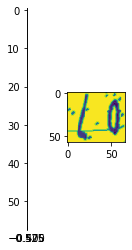

In [20]:
ir = ImageRecognition()
_,l = ir.split_image(np.array(imgs[0]))

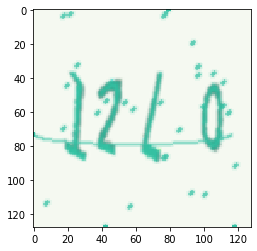

In [18]:
plt.imshow(imgs[0])

In [13]:
np.array(imgs[1]).shape

(128, 128, 3)